In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import warnings
import GF

warnings.filterwarnings("ignore")

In [2]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
npts_layer = 101

els_source = bemcs.initialize_els()
els_topo = bemcs.initialize_els()
els_b = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source) - in this case it is a semi-infinite strike-slip fault
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.75])
els_source.x2 = np.array([0])
els_source.y2 = np.array([-1e5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# topography
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)
# provide connectivity matrix
conmatrix = np.hstack(
    (
        np.arange(0, len(els_topo.x1) - 1).reshape(-1, 1),
        np.arange(1, len(els_topo.x1)).reshape(-1, 1),
    )
)
els_topo.conmatrix = conmatrix.astype(int)

In [3]:
# provide layered structure in terms of number of layers, location of layers (iterface with jump in μ), and μ values
nlayers = 10
zlayer = np.linspace(-5, 0, nlayers + 1)[0:-1]
mulayer = np.linspace(100, 1, nlayers + 1)
# mulayer[3] = 10
x1 = []
x2 = []
y1 = []
y2 = []

# calculation the dμ/dx and dμ/dy terms as α,β
conmatrix = np.zeros((nlayers * (npts_layer - 2), 2))
beta = np.zeros(nlayers * (npts_layer - 2))
for i in range(nlayers):
    xvals = np.linspace(-Lscale, Lscale, npts_layer)
    x1 = np.hstack([x1, xvals[0:-1]])
    x2 = np.hstack([x2, xvals[1:]])
    y1 = np.hstack([y1, np.ones(npts_layer - 1) * zlayer[i]])
    y2 = np.hstack([y2, np.ones(npts_layer - 1) * zlayer[i]])
    beta[i * (npts_layer - 2) : (npts_layer - 2) * (i + 1)] = (
        -(mulayer[i + 1] - mulayer[i]) / mulayer[i + 1]
    )
    conmatrix[i * (npts_layer - 2) : (npts_layer - 2) * (i + 1), :] = i * (
        npts_layer - 1
    ) + np.hstack(
        (
            np.arange(0, npts_layer - 2).reshape(-1, 1),
            np.arange(1, npts_layer - 1).reshape(-1, 1),
        )
    )

els_b.x1 = x1
els_b.x2 = x2
els_b.y1 = y1
els_b.y2 = y2
bemcs.standardize_els_geometry(els_b, reorder=False)
els_b.conmatrix = conmatrix.astype(int)

In [4]:
# combine topo and layered structure
els.x1 = np.hstack([els_topo.x1, els_b.x1])
els.x2 = np.hstack([els_topo.x2, els_b.x2])
els.y1 = np.hstack([els_topo.y1, els_b.y1])
els.y2 = np.hstack([els_topo.y2, els_b.y2])
bemcs.standardize_els_geometry(els, reorder=False)

els.conmatrix = np.concatenate(
    [els_topo.conmatrix, els_b.conmatrix + 1 + len(els_topo.conmatrix[:, 0])]
)
els.xc = els.x2[els.conmatrix[:, 0].astype(int)]
els.yc = els.y2[els.conmatrix[:, 0].astype(int)]

# label topo index
topoindex = np.zeros(len(els.xc), dtype=bool)
topoindex[0 : len(els_topo.conmatrix[:, 0])] = True

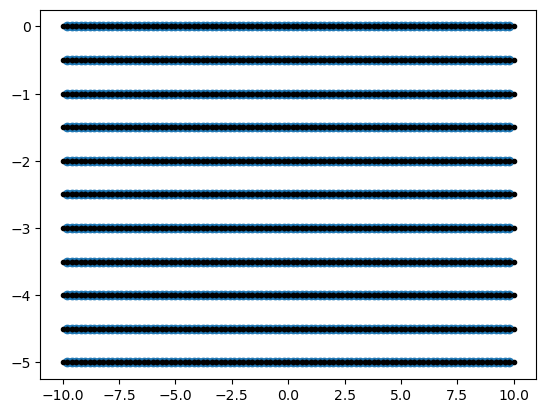

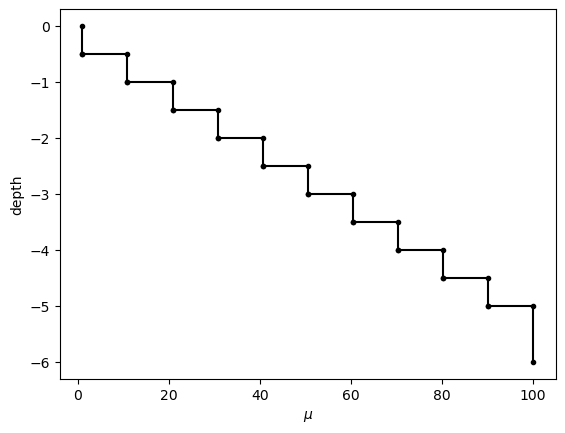

In [5]:
# plot evaluation points of new basis functions with mesh
plt.plot(els.xc, els.yc, "o")
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.show()


# plot elastic structure
plt.figure()
for i in range(nlayers):
    if i == 0:
        plt.plot(
            [mulayer[i], mulayer[i], mulayer[i + 1]],
            [zlayer[i] - 1, zlayer[i], zlayer[i]],
            "k.-",
        )
    else:
        plt.plot(
            [mulayer[i], mulayer[i], mulayer[i + 1]],
            [zlayer[i - 1], zlayer[i], zlayer[i]],
            "k.-",
        )
plt.plot(
    [mulayer[i + 1], mulayer[i + 1]],
    [zlayer[i], 0],
    "k.-",
)
plt.xlabel("$\mu$")
plt.ylabel("depth")
plt.show()

In [6]:
# need to shift observation points by an infinitesimal amount (need to figure out how to do it for the new basis functions)
dr = -1e-9
xo = els.xc  # + dr * els.x_normals
yo = els.yc + dr  # + dr * els.y_normals
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
quadcoefs = np.ones(3)

# compute grad(u) due to source at els
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
ex0 = K_sx @ quadcoefs
ey0 = K_sy @ quadcoefs

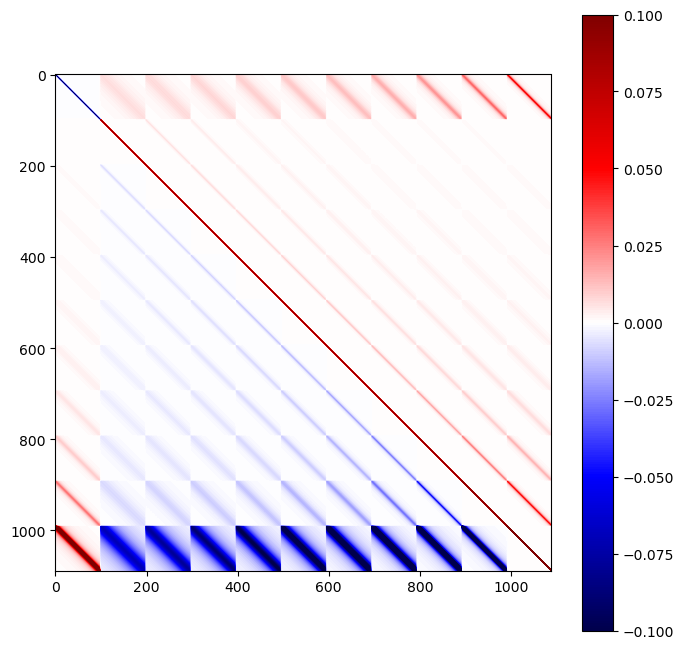

In [7]:
# compute els force kernels [Nobs x 2 x Nsources]
K_x, K_y, _ = GF.get_kernels_linforce(xo, yo, els, els.conmatrix)
# construct constant kernels from linear kernels for this simple example
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)

kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -np.repeat(beta.reshape(-1, 1), len(els_topo.conmatrix[:, 0]), axis=1)
                * K_y[~topoindex][:, topoindex],
                np.eye(len(els_b.conmatrix[:, 0]))
                - np.repeat(beta.reshape(-1, 1), len(els_b.conmatrix[:, 0]), axis=1)
                * K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)
plt.figure(figsize=(8, 8))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

In [8]:
# solve system to get body forces
rhsvec = np.vstack(
    [-ey0[topoindex].reshape(-1, 1), (beta * ey0[~topoindex]).reshape(-1, 1)]
)
print("Condition number: ", np.linalg.cond(kernel))
solvec = np.linalg.inv(kernel) @ rhsvec

# solve for purely topographic contribution
toposolvec = np.linalg.inv(K_y[topoindex][:, topoindex]) @ (
    -ey0[topoindex].reshape(-1, 1)
)

Condition number:  28.196925848299617


In [9]:
# plot resulting displacement field
nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

_, _, Ku = GF.get_kernels_linforce(xo, yo, els, els.conmatrix)

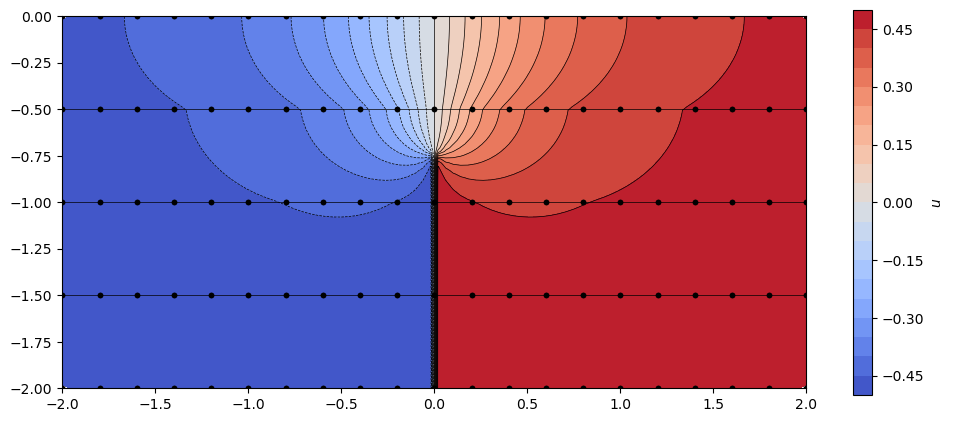

In [10]:
_, _, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els_source, mu)
# compute displacements
u = Ku @ solvec + Ku0 @ quadcoefs.reshape(-1, 1)

plt.figure(figsize=(12, 5))
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=0.5)
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.gca().set_aspect("equal", adjustable="box")